# pandas with Excel files and seaborn

*notebook by Jeffrey Aryee and Leif Denby*

In this session, you will be working with data contained in a spreadsheet. The file, named `Test_RR_TnTx_data.xlsx` contains three (3) separate sheets of Rainfall, Minimum Temperature and Maximum Temperature from the Ghana Meteorological Agency (GMet). The data is an *in situ* observation with a short term temporal span intended for the Python education. Kindly note that the acquired data must serve only the educational purpose intended.

We'll also be seeing how to use `seaborn` to produce useful plots for studying correlations and relationships in the observations. And we'll be using the `pymannkendall` package which implements the Mann-Kendall method for finding trends in the observations.

**Objectives** 

The following objectives are outlined for this lesson. Participants, at the end of the lesson should have adequate knowledge in the following:

1.	[Loading data from an excel spreadsheet using Pandas](#1.-Loading-data-from-.xlsx-Excel-spreadsheet-file)
2.  [Reshaping spreadsheet data](#2.-Reshaping-spreadsheet-data)
3.  [Visualisation with seaborn](#3.-Visualisation-with-seaborn)
4.  [Data slicing and groupby](#4.-Grouping-Data-with-Groupby()-function)
4.	[Working with timeseries data](#5.-Working-with-timeseries-data)
5.	[Extreme Indices (Rnnmm, percentile differences)](#6.-Extreme-Rainfall-Events)
6.	[Quantifying trends](#7.-Trend-Assessmet-using-PyMannKendall)

***Let's start by importing relevant packages.***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb  # Useful for artistic and more scientific data visualization
import pymannkendall as mk  # Useful Python package for identifying Mann-Kendall trends in a dataset.

from pathlib import Path

In [2]:
data_path = Path("../data")

## 1. Loading data from `.xlsx` Excel spreadsheet file

We'll now read in the rainfall and temperature data from different sheets in a single `.xslx` Excel spreadsheet file. This is done with the `pd.read_excel` function.

Note: the `xlrd` package (which `pandas` used to use for reading `.xslx`-files) [recently removed support for `.xslx`-files](https://stackoverflow.com/a/65266270/271776)). Fortunately `pandas` can use `openpyxl` instead, but unless you pandas version `>=1.2.0` you will have to tell `pandas` to use `openpyxl` using the `engine='openpyxl'` argument when opening a file (as we do below).

Sheet **RR** contains Daily Rainfall Totals, sheet **Tn** contains Daily Minimum Temperature and **Tx** contains the Daily Maximum Temperature data.

In [3]:
filepath_spreadsheet = data_path / "Test_RR_TnTx_data.xlsx"
# Rainfall
df_RR = pd.read_excel(filepath_spreadsheet, sheet_name="RR", engine="openpyxl")
# Minimum Temperature
df_TN = pd.read_excel(filepath_spreadsheet, sheet_name="Tn", engine="openpyxl")
# Maximum Temperature
df_TX = pd.read_excel(filepath_spreadsheet, sheet_name="Tx", engine="openpyxl")

In each sheet, the data is stored as:

- **Column A :** the Station Name (for 3 stations, namely: Tamale, Kumasi and Tema).
- **Column B :** abbreviation of parameter of interest (eg. RR for rainfall)
- **Column C :** Year of observation
- **Column D :** Month of observation
- **Columns E to AI :** Daily Data (Day 1 to maximum days in the month. Eg. Columns E to AI on the second rows contains data for 1st to 31st January 2010)

The first row contains the headers of each column and `pandas` uses this to set the column names

Let's have a look at the first few rows of the loaded rainfall data

In [4]:
df_RR.head()

,Name,Eg El Abbreviation,Year,Month,Val01,Val02,Val03,Val04,Val05,Val06,...,Val22,Val23,Val24,Val25,Val26,Val27,Val28,Val29,Val30,Val31
0,Tamale,RR,2010,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Tamale,RR,2010,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,Tamale,RR,2010,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tamale,RR,2010,4,0.0,0.0,0.0,0.0,0.9,0.0,...,89.1,0.0,0.0,0.0,73.3,1.5,0.0,0.0,0.0,NaN
4,Tamale,RR,2010,5,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.6


## 2. Reshaping spreadsheet data

We want to turn this tabular data from this "wide"-format, where each row contains more than one value to one where there is only one value per row. I.e. we want to reshape this table from one where each row contains each data for a each individual day in a given month and year, to one where one row only contains the rain for a single year, month and day.

For this operation (which is the opposite to creating a "pivot" on the data) we can use pandas's [DataFrame.melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html) method. In it we provide which columns contain the "id" of a data-value (i.e. which columns are label for the data) and the rest are then assumed to be columns containing data (which columns to use for data can explicitly be given with the `value_vars` variable):

In [5]:
df_RR.melt(
    id_vars=[
        "Name",
        "Eg El Abbreviation",
        "Year",
        "Month",
    ],
)

,Name,Eg El Abbreviation,Year,Month,variable,value
0,Tamale,RR,2010,1,Val01,0.0
1,Tamale,RR,2010,2,Val01,0.0
2,Tamale,RR,2010,3,Val01,0.0
3,Tamale,RR,2010,4,Val01,0.0
4,Tamale,RR,2010,5,Val01,0.0
...,...,...,...,...,...,...
4459,Tema,RR,2013,8,Val31,0.0
4460,Tema,RR,2013,9,Val31,NaN
4461,Tema,RR,2013,10,Val31,0.0
4462,Tema,RR,2013,11,Val31,NaN


This is almost here, though we would prefer to have the actual day of the month rather than `Val01`, `Val02` etc. To achieve this we just need to rename the columns before we apply the `.melt` operation. We can also tell pandas what we want the column that contains these labels to be called, we'll make that `Day`

In [6]:
fields_to_rename = {f"Val{n:02d}": n for n in range(1, 32)}
fields_to_rename

{'Val01': 1,
 'Val02': 2,
 'Val03': 3,
 'Val04': 4,
 'Val05': 5,
 'Val06': 6,
 'Val07': 7,
 'Val08': 8,
 'Val09': 9,
 'Val10': 10,
 'Val11': 11,
 'Val12': 12,
 'Val13': 13,
 'Val14': 14,
 'Val15': 15,
 'Val16': 16,
 'Val17': 17,
 'Val18': 18,
 'Val19': 19,
 'Val20': 20,
 'Val21': 21,
 'Val22': 22,
 'Val23': 23,
 'Val24': 24,
 'Val25': 25,
 'Val26': 26,
 'Val27': 27,
 'Val28': 28,
 'Val29': 29,
 'Val30': 30,
 'Val31': 31}

In [7]:
df_RR.rename(columns=fields_to_rename, inplace=True)
df_RR

,Name,Eg El Abbreviation,Year,Month,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,Tamale,RR,2010,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Tamale,RR,2010,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,Tamale,RR,2010,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tamale,RR,2010,4,0.0,0.0,0.0,0.0,0.9,0.0,...,89.1,0.0,0.0,0.0,73.3,1.5,0.0,0.0,0.0,NaN
4,Tamale,RR,2010,5,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Tema,RR,2013,8,0.0,0.0,0.0,0.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,Tema,RR,2013,9,0.1,0.0,0.0,0.0,6.5,0.0,...,0.0,7.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
141,Tema,RR,2013,10,0.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,Tema,RR,2013,11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.8,0.0,4.9,0.0,0.0,0.0,0.0,9.9,NaN


We now call `.melt` again, and specify what we want the column which contains the day-numbers to be called.

We'll also use the `.dropna()` function to get rid of any rows where the value is NaN (which for example will be on days where the month doens't have 31 days)

In [8]:
df_RR_flat = df_RR.melt(
    id_vars=[
        "Name",
        "Eg El Abbreviation",
        "Year",
        "Month",
    ],
    var_name="Day",
).dropna()
df_RR_flat

,Name,Eg El Abbreviation,Year,Month,Day,value
0,Tamale,RR,2010,1,1,0.0
1,Tamale,RR,2010,2,1,0.0
2,Tamale,RR,2010,3,1,0.0
3,Tamale,RR,2010,4,1,0.0
4,Tamale,RR,2010,5,1,0.0
...,...,...,...,...,...,...
4456,Tema,RR,2013,5,31,0.0
4458,Tema,RR,2013,7,31,0.0
4459,Tema,RR,2013,8,31,0.0
4461,Tema,RR,2013,10,31,0.0


Additionally, we'd like to have the full date defined in a single column instead of having the components of the date split into three different columns. To achieve this we can use the [pd.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) function (you should click and have a look at its documentation). This function is so clever that if you pass it a DataFrame which contains columns with names `year`, `month`, `day`, `hour` etc it will automatically work out how to combine these and produce a single `pd.DataSeries` with datetimes that we can add as a new column to our exising dataframe.

In [9]:
pd.to_datetime(df_RR_flat[["Year", "Month", "Day"]])

0      2010-01-01
1      2010-02-01
2      2010-03-01
3      2010-04-01
4      2010-05-01
          ...    
4456   2013-05-31
4458   2013-07-31
4459   2013-08-31
4461   2013-10-31
4463   2013-12-31
Length: 4383, dtype: datetime64[ns]

In [10]:
df_RR_flat["date"] = pd.to_datetime(df_RR_flat[["Year", "Month", "Day"]])
df_RR_flat

,Name,Eg El Abbreviation,Year,Month,Day,value,date
0,Tamale,RR,2010,1,1,0.0,2010-01-01
1,Tamale,RR,2010,2,1,0.0,2010-02-01
2,Tamale,RR,2010,3,1,0.0,2010-03-01
3,Tamale,RR,2010,4,1,0.0,2010-04-01
4,Tamale,RR,2010,5,1,0.0,2010-05-01
...,...,...,...,...,...,...,...
4456,Tema,RR,2013,5,31,0.0,2013-05-31
4458,Tema,RR,2013,7,31,0.0,2013-07-31
4459,Tema,RR,2013,8,31,0.0,2013-08-31
4461,Tema,RR,2013,10,31,0.0,2013-10-31


The last thing we want to do is get rid of the columns we don't need anymore (`Eg El Abbrevation`, `Year`, `Month` and `Day`), make the new `date` column the index and finally split the stations into separate columns so that we can get the data just for the Tamale station by selecting its column.

In [11]:
# pick out the columns we want to keep and set the "date" column as the index
df_RR_flat[["Name", "value", "date"]].set_index("date")

,Name,value
date,,
2010-01-01,Tamale,0.0
2010-02-01,Tamale,0.0
2010-03-01,Tamale,0.0
2010-04-01,Tamale,0.0
2010-05-01,Tamale,0.0
...,...,...
2013-05-31,Tema,0.0
2013-07-31,Tema,0.0
2013-08-31,Tema,0.0


Turning the dataframe back from this "long"-format with one entry-per-row to one with a column for each station, is the opposite of the `.melt` operation we did earlier. To do this kind of operation in pandas we can use the [DataFrame.pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html#pandas.DataFrame.pivot) function; we simply say we want to pivot on the `Name` column:

In [12]:
df_RR_flat[["Name", "value", "date"]].set_index("date").pivot(columns="Name")

value             
Name       Kumasi Tamale  Tema
date                          
2010-01-01    0.0    0.0   0.0
2010-01-02    0.0    0.0   0.0
2010-01-03    0.0    0.0   0.0
2010-01-04    0.0    0.0   0.0
2010-01-05    0.0    0.0   0.0
...           ...    ...   ...
2013-12-27    0.0    0.0   0.0
2013-12-28    0.0    0.0   0.0
2013-12-29    0.0    0.0   0.0
2013-12-30    0.0    0.0  24.8
2013-12-31   15.1    0.0   0.0

[1461 rows x 3 columns]

You will see that the `value`-label is hovering above the name of the stations. That is because the numbers in the `value` column now have formed an axes in our data. We can simply pick out that axes just like we pick out columns, and we have the final result we wanted:

In [13]:
df_RR_flat[["Name", "value", "date"]].set_index("date").pivot(columns="Name")["value"]

Name,Kumasi,Tamale,Tema
date,,,
2010-01-01,0.0,0.0,0.0
2010-01-02,0.0,0.0,0.0
2010-01-03,0.0,0.0,0.0
2010-01-04,0.0,0.0,0.0
2010-01-05,0.0,0.0,0.0
...,...,...,...
2013-12-27,0.0,0.0,0.0
2013-12-28,0.0,0.0,0.0
2013-12-29,0.0,0.0,0.0


Let's wrap all this functionality we just wrote into a single function that we can apply on the data-frame we originally loaded. This will make it really clear (when we come back another day say) what steps we went through, and makes it easy to apply the operations to each sheet (rain amount, minimum temperature and maximum temperature). Because every pandas operation on a `DataFrame` returns a new `DataFrame` we can use what is often called [method-chaining](https://towardsdatascience.com/using-pandas-method-chaining-to-improve-code-readability-d8517c5626ac) to make the code a lot easier to read:

In [14]:
def reshape_from_monthrows_to_daily(df):
    """
    Take a station-data DataFrame (loaded from a Excel spredsheet)
    with values per day in a given months a columns and month, year and station by row
    and reshape into data per date with stations given as columns
    """
    fields_to_rename = {f"Val{n:02d}": n for n in range(1, 32)}

    df_flat = (
        df.rename(columns=fields_to_rename, inplace=False)
        .melt(
            id_vars=[
                "Name",
                "Eg El Abbreviation",
                "Year",
                "Month",
            ],
            var_name="Day",
        )
        .dropna()
    )

    # add the date column, we've added `errors="coerse"` here because the max temperature data appears
    # to include an invalid dates, for these rows the "date" will be set as NaT (nan-time)
    df_flat["date"] = pd.to_datetime(df_flat[["Year", "Month", "Day"]], errors="coerce")

    # drop all NaT rows, the `~` means not, i.e. keep only values where the date is not NaT
    df_flat = df_flat[~pd.isnull(df_flat["date"])]

    return (
        df_flat[["Name", "value", "date"]]
        .set_index("date")
        .pivot(columns="Name")["value"]
    )


reshape_from_monthrows_to_daily(df_RR)

Name,Kumasi,Tamale,Tema
date,,,
2010-01-01,0.0,0.0,0.0
2010-01-02,0.0,0.0,0.0
2010-01-03,0.0,0.0,0.0
2010-01-04,0.0,0.0,0.0
2010-01-05,0.0,0.0,0.0
...,...,...,...
2013-12-27,0.0,0.0,0.0
2013-12-28,0.0,0.0,0.0
2013-12-29,0.0,0.0,0.0


In [15]:
# this can also be applied to the temperature data
reshape_from_monthrows_to_daily(df_TN)

Name,Kumasi,Tamale,Tema
date,,,
2010-01-01,22.7,20.500000,26.1
2010-01-02,22.5,18.300000,26.0
2010-01-03,23.2,16.700000,25.9
2010-01-04,23.4,16.000000,27.0
2010-01-05,22.5,14.200000,26.5
...,...,...,...
2013-12-27,22.2,17.400000,25.2
2013-12-28,22.5,16.733333,26.2
2013-12-29,24.0,16.466667,26.5


In [16]:
df_TX

,Name,Eg El Abbreviation,Year,Month,Val01,Val02,Val03,Val04,Val05,Val06,...,Val22,Val23,Val24,Val25,Val26,Val27,Val28,Val29,Val30,Val31
0,Tamale,Tx,2010,1,36.0,35.8,36.9,36.6,37.1,37.5,...,37.4,37.6,37.7,38.8,38.7,39.2,38.5,39.5,40.5,40.5
1,Tamale,Tx,2010,2,38.4,39.8,39.6,39.0,38.4,38.0,...,38.7,40.1,40.6,40.2,39.0,39.7,40.5,NaN,NaN,NaN
2,Tamale,Tx,2010,3,39.2,39.5,40.6,40.2,39.6,39.2,...,36.4,37.5,37.7,38.0,40.0,40.5,39.5,40.0,39.6,39.5
3,Tamale,Tx,2010,4,40.6,40.0,39.5,39.5,39.6,34.5,...,39.4,33.5,34.5,34.5,34.4,28.8,33.7,35.5,34.0,NaN
4,Tamale,Tx,2010,5,35.4,34.1,35.0,35.1,34.8,33.8,...,35.6,36.6,34.2,37.0,34.5,36.6,37.0,35.5,33.8,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Tema,Tx,2013,8,27.0,26.6,26.5,27.8,28.5,27.0,...,27.6,28.4,27.8,28.0,28.1,28.4,28.7,28.8,28.1,27.7
140,Tema,Tx,2013,9,28.4,27.8,28.1,29.0,29.0,27.5,...,29.5,28.1,26.6,28.0,28.2,28.2,28.2,28.6,29.2,NaN
141,Tema,Tx,2013,10,30.0,29.0,29.9,32.0,30.0,29.6,...,30.2,30.8,31.2,31.0,31.0,30.6,31.5,31.0,30.8,31.5
142,Tema,Tx,2013,11,31.7,31.2,31.0,31.3,31.0,31.0,...,31.1,31.5,29.1,30.5,31.1,31.2,31.5,32.0,32.0,NaN


In [17]:
df_RR_by_station = reshape_from_monthrows_to_daily(df_RR)
df_TN_by_station = reshape_from_monthrows_to_daily(df_TN)
df_TX_by_station = reshape_from_monthrows_to_daily(df_TX)

The process we've just gone through is often called "data wrangling":

**What is Data Wrangling?**

Data wrangling is the process of cleaning, structuring and enriching raw data into a desired format for better decision making in less time. Data wrangling is increasingly ubiquitous. In simpler terms, data wrangling (sometimes referred to as data munging) entails transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics. 
Data has become more diverse and unstructured, demanding increased time spent culling, cleaning, and organizing data ahead of broader analysis. <br>

**Reference:** <br>
> https://www.trifacta.com/data-wrangling/ <br>
> https://en.wikipedia.org/wiki/Data_wrangling <br><br><br>



With this premise established, we will wrangle the rainfall/temperature data, and this will be addressed as such.

> Vertically stacking the data using a DateTime index <br>
> Basic manipulation and dealing with missing values <br>
> Resampling to a different frequency
---------------------------------------------------------------------------------------------------------------------------------

## 3. Visualisation with `seaborn`

Seaborn is a Python data visualization library based on matplotlib **(https://seaborn.pydata.org/)**. It provides a high-level interface for drawing attractive and informative statistical graphics. `seaborn` can be installed with `pip` and `conda` as other python packages.

### KDE Plot

Let's start off with data distribution plots using Seaborn's Kernel Density Estimates (KDE), which is a method for estimating the underlying distribution that data is sampled from by smoothing the sampled using a Gaussian kernel. KDE represents the data using a continuous probability density curve in one or more dimensions. There are other ways of estimating the distribution. <br>

Seaborn allows us to visualize the distribution of these observations, analagous to a histogram. 

Text(0.5, 0, 'Rainfall (mm)')

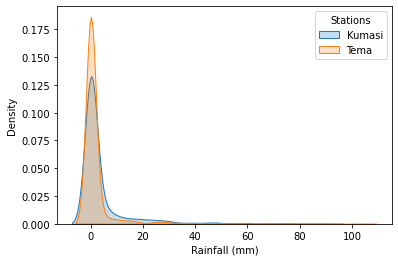

In [18]:
#### Sample Seaborn Visualizations
sb.kdeplot(
    df_RR_by_station["Kumasi"].astype(float), legend=True, shade=True
)  # Distribution plot
sb.kdeplot(
    df_RR_by_station["Tema"].astype(float), legend=True, shade=True
)  # Distribution plot

plt.legend(title="Stations", loc="upper right", labels=["Kumasi", "Tema"])
plt.xlabel("Rainfall (mm)")

### Scatter Plot

Scatter plots represent values for two different numeric variables. Scatter plots are used to observe relationships between the two variables.

> Let's attempt to see if there's a synergy in the rainfall events in any two locations (eg. Kumasi and Tema)

Text(0.5, 1.0, 'Rainfall in Kumasi against Tema')

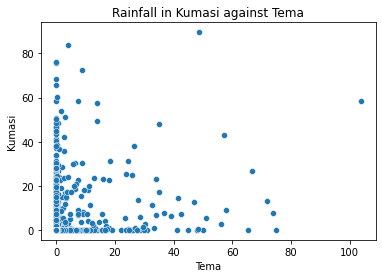

In [19]:
sb.scatterplot(y="Kumasi", x="Tema", data=df_RR_by_station)
plt.title("Rainfall in Kumasi against Tema")

### Joint Plot

Seaborn's jointplot draws a plot of two variables with bivariate and univariate graphs. The bivariate plot (bottom left) produces a clustered diagram, which is useful in cluster analysis.

> Histograms rather produced an error when this command was originally issued. This may not be same in your case. However, as control, the dataset was formatted to floats by using the astype() method and passing the function float as an argument. 

(0.0, 40.0)

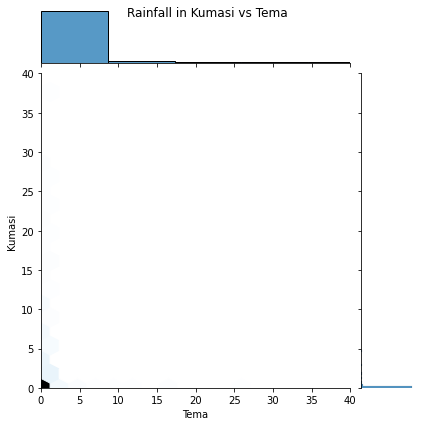

In [20]:
sb.jointplot(x="Tema", y="Kumasi", data=df_RR_by_station, kind="hex")
plt.suptitle("Rainfall in Kumasi vs Tema \n\n\n")
plt.xlim(0, 40)
plt.ylim(0, 40)

## 4. Grouping Data with Groupby() function

Let's replicate the jointplot using monthly rainfall totals. Here, we will utilise the pandas groupby() function, in tandem with the Pandas Grouper class.

The Pandas groupby() method allows for creating categories or groupings, for groupwise approximations, function applications, etc.

```python
df.groupby(pd.Grouper(freq='Y')).aggregate(np.sum).plot()  # Annual Total
df.groupby(pd.Grouper(freq='M')).aggregate(np.sum).plot()  # Monthly Total
```

Alternatively, we can use the resample method (shown below): <br>

```python
df.resample('M').sum()   # Monthly Total
df.resample('Y').sum()   # Annual Total
```

You notice that we utilise the `pd.Grouper` class. A `Grouper` allows you to specify a groupby instruction for an object. This specification will select a column via the key parameter, or if the level and/or axis parameters are given, a level of the index of the target object. If axis and/or level are passed as keywords to both Grouper and groupby, the values passed to Grouper take precedence. In the example above, we pass the frequency as a datetime format (eg. "Y" for year, "M" for month, "MS" for start of month, etc.). This allows for grouping the dataframe into either yearly (first example) or monthly (second example) categories.

Thereafter, we employ the aggregate function, while passing as argument, the numpy summation function (`np.sum`). This produces the summation of each monthly or yearly grouping.

Now, let's replicate the jointplot using monthly rainfall totals.

Text(0.5, 0.98, 'Rainfall in Kumasi against Tema \n\n\n')

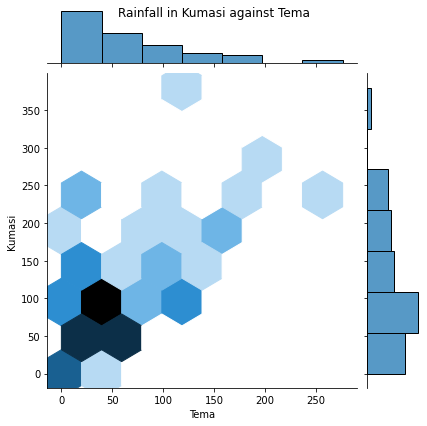

In [21]:
sb.jointplot(
    x="Tema",
    y="Kumasi",
    data=df_RR_by_station.groupby(pd.Grouper(freq="M")).sum(),
    kind="hex",
)
plt.suptitle("Rainfall in Kumasi against Tema \n\n\n")

Pair Plot
----------------------------
A simple way of identifying relations between each numerical series of a dataframe.

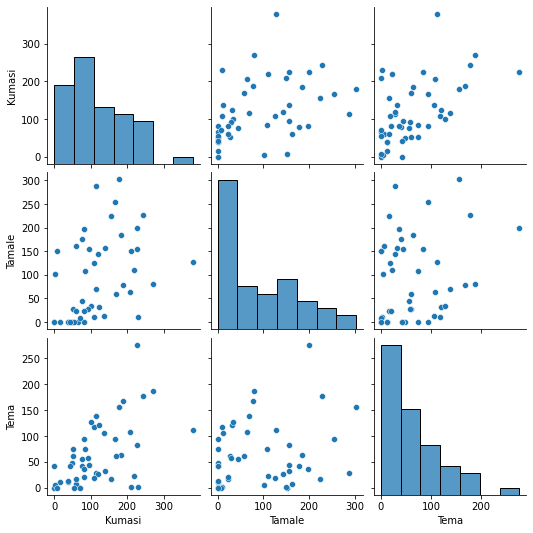

In [22]:
sb.pairplot(df_RR_by_station.groupby(pd.Grouper(freq="M")).sum(), diag_kind="hist")

## 5. Working with timeseries data

By providing `subplots=True` to `DataFrame.plot(...)` each column will be put into its own subplot. The call will return the axes that the data was plotted into and we can then iterate over these to set the attributes of the plot that we would like:

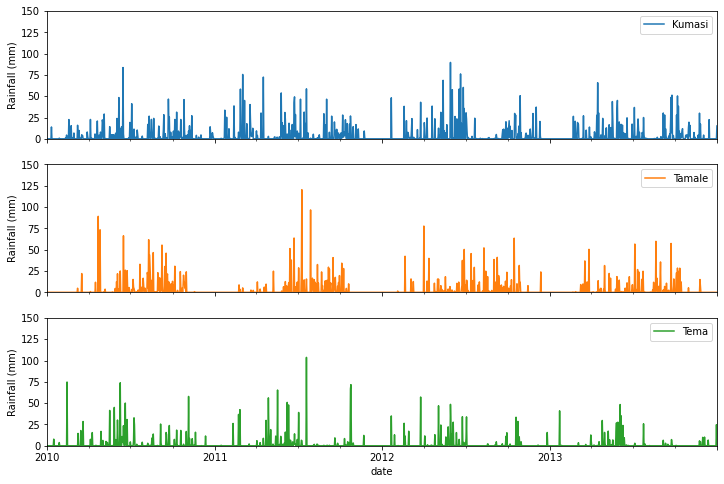

In [23]:
axes = df_RR_by_station.plot(linestyle="-", figsize=(12, 8), subplots=True)
for ax in axes:
    ax.set_ylabel("Rainfall (mm)")
    ax.set_ylim(0, 150)

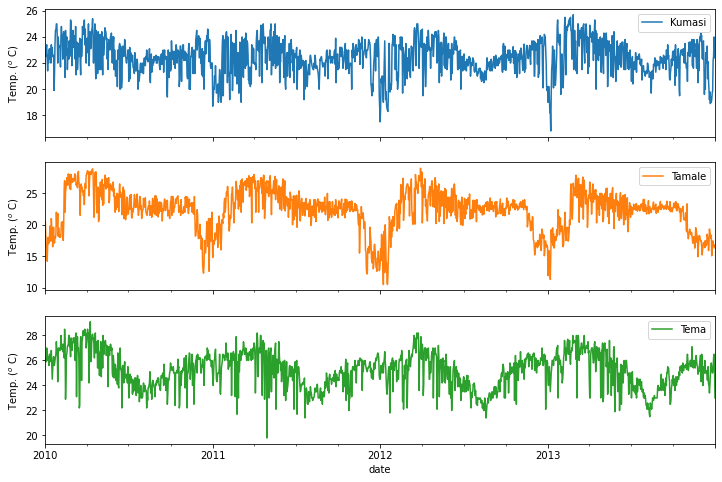

In [24]:
# We can repeat this for the daily minimum temperature data.
axes = df_TN_by_station.plot(linestyle="-", figsize=(12, 8), subplots=True)
for ax in axes:
    ax.set_ylabel(r"Temp. ($^o$ C)")

### grouped time-seires

We can also use the group-by operations to get resampled timeseries. 

```python
df.groupby(pd.Grouper(freq='Y')).aggregate(np.sum).plot()  # Annual Total
df.groupby(pd.Grouper(freq='M')).aggregate(np.sum).plot()  # Monthly Total
```

<AxesSubplot:xlabel='date'>

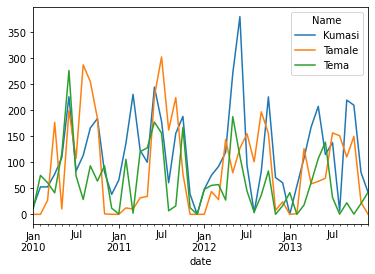

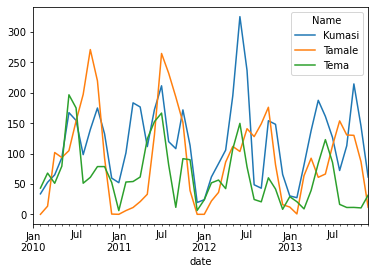

In [25]:
#### Moving Averages
df_Month_Data = df_RR_by_station.groupby(pd.Grouper(freq="M")).aggregate(np.sum)
df_Month_Data.plot()
df_Month_Data.rolling(2).mean().plot()

## 6. Extreme Rainfall Events

- **Rainy Days :** rainfall amount above 1 mm<br />
- **Rnnmm (eg. R10mm, R20mm, R50mm) :** events with rainfall amount above 10 mm, 20mm, and 50 mm respectively. <br>
- **Percentile** 

An alternative for identifying elements of a dataframe that meet a specific criteria is to pass the criteria within a square brackets attached to the dataframe. <br>

**For example:** <br>
> **a[a>1]** implies extracting all **a** elements where the value of **a** exceeds 1.<br><br>

We will employ this simplistic indexing method to map out rainy days and rainfall extremes.

In [26]:
df_Rainy_days = (
    df_RR_by_station[df_RR_by_station >= 1].groupby(pd.Grouper(freq="M")).count()
)  # Count of Rainy Days per month
df_R10mm = (
    df_RR_by_station[df_RR_by_station >= 10].groupby(pd.Grouper(freq="M")).count()
)  # Count of R10mm events per month
df_R20mm = (
    df_RR_by_station[df_RR_by_station >= 20].groupby(pd.Grouper(freq="M")).count()
)  # Count of R20mm events per month
df_R50mm = (
    df_RR_by_station[df_RR_by_station >= 50].groupby(pd.Grouper(freq="M")).count()
)  # Count of R50mm events per month

<AxesSubplot:xlabel='date'>

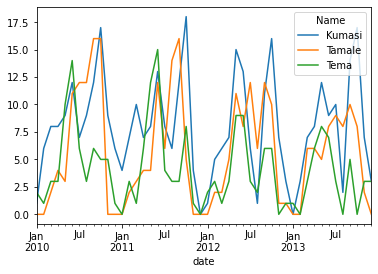

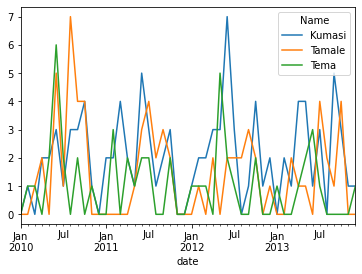

In [27]:
df_Rainy_days.plot()
df_R20mm.plot()

**Let's quantify the rainfall extremes using the percentile approach**<br>

> 1. First, we compute the 95th percentile of the rainfall data using **.quantile(.95)** method. This serves as the threshold for extreme events. 
> 2. Next, we subtract the 95th percentile rainfall amount from the entire data series.

> 3. Afterwards, we employ the .where() method to map out where there is a positive difference (indicating an extreme event), and then ... 
> 4. we use .count() to quantify the number of these extreme events.

Text(0.5, 1.0, 'Events above the Percentile')

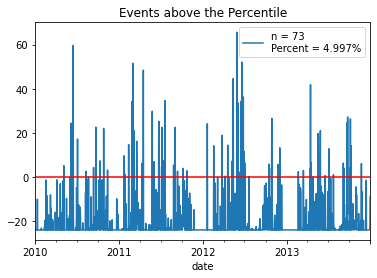

In [28]:
perc=df_RR_by_station['Kumasi'].quantile(.95)   #This produces the 95th percentile value.
diff=(df_RR_by_station['Kumasi']-perc)
Events_95 = diff.where(diff>0).count()
percentage=round((Events_95/diff.count())*100, 3) #Compute the percentage of extreme events in a defined station
diff.plot(label='n = '+str(Events_95)+'\nPercent = '+str(percentage)+'%')
plt.axhline(y=0, color='r')
plt.legend()
plt.title('Events above the Percentile')



## 7. Trend Assessmet using PyMannKendall

Pymannkendall (**https://pypi.org/project/pymannkendall/**) allows for trend assessment in a dataset/observation. The package details out numerous sub-packages that are useful for various forms of trend assessment. For simplicity, we will focus on the Mann-Kendall original test. Nonetheless, feel free to try out its numerous trend assessment types after the class. [publication](https://www.researchgate.net/publication/334688255_pyMannKendall_a_python_package_for_non_parametric_Mann_Kendall_family_of_trend_tests)

In [29]:
import pymannkendall as mk

mk.original_test?

In [30]:
# Trends In Data With PyMannKendall
mk.original_test(df_RR_by_station["Kumasi"].astype(float))

Mann_Kendall_Test(trend='no trend', h=False, p=0.8654923860158847, z=-0.16938682484329096, Tau=-0.0024978200331917527, s=-2664.0, var_s=247162784.0, slope=0.0, intercept=0.0)

The output from the above cell provides <br>

**Output:**
>    trend: tells the trend (increasing, decreasing or no trend)<br>
>    h: True (if trend is present) or False (if trend is absence)<br>
>    p: p-value of the significance test (eg. P<0.05 implies data is significant at 95% confidence level)  <br>
>    z: normalized test statistics <br>
>    Tau: Kendall Tau <br>
>    s: Mann-Kendal's score <br>
>    var_s: Variance S <br>
>    slope: sen's slope <br>

Next, we attempt to produce the slopes for each given station's monthly rainfall totals

In [31]:
stations = df_RR_by_station.columns

for station in stations:
    print(
        station,
        mk.original_test(
            df_RR_by_station[station]
            .groupby(pd.Grouper(freq="M"))
            .sum()
            .dropna()
            .astype(float)
        ).slope,
    )

Kumasi 0.3897727272727275
Tamale 0.0
Tema -0.7999999999999992


In [32]:
df_TX_by_station

Name,Kumasi,Tamale,Tema
date,,,
2010-01-01,31.8,36.000000,30.7
2010-01-02,33.5,35.800000,30.8
2010-01-03,33.1,36.900000,31.0
2010-01-04,33.0,36.600000,31.0
2010-01-05,31.0,37.100000,32.0
...,...,...,...
2013-12-27,31.2,36.819444,32.0
2013-12-28,33.1,36.700000,31.7
2013-12-29,30.0,37.080556,31.8


## Exercise 1


Produce standardized anomaly plots (formula below) of Daily Mean Temperature for the different stations and visualize it. The Standardized Anomaly $z$ is defined as $z_i = \frac{T_i - <T>}{\sigma_T}$, where $<T>$ is the mean of temperature and $\sigma_T$ is the standard deviation of temperature.
- Hint: First, build a function of standardized anomaly (You can use the default function build in python or better still, make use of lambda functions.) Second, pass Tavg through the function, and plot out.

## Exercise 2

For the stacked data: <br><br>
    1. Compute Monthly and Annual Mean Temperature <br>
    2. Identify the trends and magnitude of slope in the computed means in (1).<br>
    3. Using seaborn jointplot, let's produce a cluster plot of temperature and rainfall in any of the other locations. <br>

# Reshaping the data without `.melt` and `.pivot`

It is possible to reshape the data without using the `DataFrame.melt` and `DataFrame.pivot` functions as we did above, but this involves a lot more work. Because we also have to loop through each row manually it will also be a lot slower as compared to the built-in functions (as these can parallelise the operations).

For completeness we will go through how one would do it manually here:

In [38]:
import calendar  # We need the calendar package to generate certain calendar properties
from datetime import datetime
from dateutil import parser

In [39]:
# let's load the data again

filepath_spreadsheet = data_path / "Test_RR_TnTx_data.xlsx"
# Rainfall
df_RR = pd.read_excel(filepath_spreadsheet, sheet_name="RR", engine="openpyxl")
# Minimum Temperature
df_TN = pd.read_excel(filepath_spreadsheet, sheet_name="Tn", engine="openpyxl")
# Maximum Temperature
df_TX = pd.read_excel(filepath_spreadsheet, sheet_name="Tx", engine="openpyxl")

We set the day number as column headers.

In [40]:
df_RR.columns.values[4:] = np.arange(1, 32).astype("str")
df_TN.columns.values[4:] = np.arange(1, 32).astype("str")
df_TX.columns.values[4:] = np.arange(1, 32).astype("str")

In [41]:
df_RR.columns

Index(['Name', 'Eg El Abbreviation', 'Year', 'Month', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31'],
      dtype='object')

In the next part, we select only the columns containing the year, month and daily data. We will be vertically stacking these using a defined function. In the end, the datasets should look somewhat like this:

19800101  RR1 <br>
19800102  RR2 <br>
... <br>
... <br>
... <br>
20201231 RRN

In [42]:
df_RR2s = df_RR.iloc[:, 2:]
df_TN2s = df_TN.iloc[:, 2:]
df_TX2s = df_TX.iloc[:, 2:]
df_RR2s.head(2)

,Year,Month,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,2010,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [43]:
# Let generate a new dataframe with index for each day within the observation period.
# We begin with the date creation using pandas date_range function

# Default frequency is daily
date = pd.date_range(start="1/1/2010", end="31/12/2013", freq="D")
type(date)  ### returns pandas.core.indexes.datetimes.DatetimeIndex

# Next, we populate a new dataframe with the actual data
df_NewRRData = pd.DataFrame(date, columns=["date"])
df_NewTNData = pd.DataFrame(date, columns=["date"])
df_NewTXData = pd.DataFrame(date, columns=["date"])

# Set the date as index of the new DataFrame.
df_NewRRData.set_index("date", inplace=True)
df_NewTNData.set_index("date", inplace=True)
df_NewTXData.set_index("date", inplace=True)

In [44]:
df_NewRRData.head()

""
date
2010-01-01
2010-01-02
2010-01-03
2010-01-04
2010-01-05


Here, we will code a function that will help to transform the data in a column data timeseries. 

In [45]:
# Self-defined function to stack row-oriented data as columnar
def data_stacking(d, df, s):
    year = np.int_(d["Year"])  # Format years as integers
    month = np.int_(d["Month"])  # Format months as integers

    # Let's create a blank column for the given station (s) which allows for appending data.
    df[s] = None

    for i in d.index:
        # Looping through the years and month and producing the total number of days in each month of the year.
        # We employ calendar.monthrange() to acquire the total number of days in a given month.
        # Within the datasets, there are 31 column for each month data. By specifying the total number of actual days in a month, we omit the excess NaNs
        # in the end when matching data from the existing data set to the new vertically stacked data, using the dates as reference index.
        total_days = calendar.monthrange(
            datetime.strptime(str(year[i]), "%Y").year,
            datetime.strptime(str(month[i]), "%m").month,
        )[1]

        for day in range(
            1, total_days + 1
        ):  # for months with n days, we create a range of 1 to n+1 days to produce the exact n days. (eg. range(1,32) produces days 1 to 31)
            date_index = datetime.date(
                datetime.strptime(f"{year[i]} {month[i]} {day}", "%Y %m %d")
            )

            # Populating the new data with exact data from the old set for the same day.
            df[s].loc[pd.to_datetime(date_index)] = d.iloc[i, day + 1]

    return df  # return the stacked Data

Start with one station and then move to multiples

In [46]:
# Selecting Data for only one station
d = df_RR2s.where(df_RR.Name == "Tema")

# Remove all the other rows where the year column contains NaNs. This will omit all other stations except Tema.
d = d[d["Year"].notna()]

d.index = range(len(d.index))  # Re-indexing the sliced data to start from 0.

In [47]:
d.shape, df_NewRRData.shape

((48, 33), (1461, 0))

In [48]:
# Single Station (Data Stacking via self-defined function)
df_NewRRData = data_stacking(d, df_NewRRData, "Tema")
df_NewRRData.head(2)

,Tema
date,
2010-01-01,0.0
2010-01-02,0.0


We attempt to loop through all the given stations and stack them to the new dataframe. To generate the list of stations without duplicates, we simply use the set() function which produce a set of any identified list without duplicates. We then pass it as a list to allow us loop through them easily, while stacking to the defined dataframe.

In [49]:
# Creating Multiple columns for different stations
stations = sorted(list(set(df_RR.Name)))
for s in stations:
    d = df_RR2s.where(df_RR.Name == s)
    d = d[d["Year"].notna()]
    # for multi station data, we reset the index to start from 0 to the total rows per station data.
    d.index = range(len(d.index))
    df_NewRRData = data_stacking(d, df_NewRRData, s)

df_NewRRData.head(3)

,Tema,Kumasi,Tamale
date,,,
2010-01-01,0.0,0.0,0.0
2010-01-02,0.0,0.0,0.0
2010-01-03,0.0,0.0,0.0


Can we recreate the stacked data for the minimum and maximum temperature data too?
----------------------------------------------------------------------------------------------------------------------------

In [50]:
stations=sorted(list(set(df_RR.Name)))
for s in stations:
    d = df_TN2s.where(df_TN.Name==s)
    d = d[d['Year'].notna()]
    # for multi station data, we reset the index to start from 0 to the total rows per station data.
    d.index=range(len(d.index)) 
    df_NewTNData=data_stacking(d, df_NewTNData, s)
    
    d = df_TX2s.where(df_TX.Name==s)
    d = d[d['Year'].notna()]
    # for multi station data, we reset the index to start from 0 to the total rows per station data.
    d.index=range(len(d.index)) 
    df_NewTXData=data_stacking(d, df_NewTXData, s)
